<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 1474, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 1474 (delta 13), reused 22 (delta 9), pack-reused 1444 (from 1)
Receiving objects: 100% (1474/1474), 13.73 MiB | 25.83 MiB/s, done.
Resolving deltas: 100% (996/996), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import  trainer_stage2
from kltn.utils.metrics import  DiceMetric, TverskyLossWSigmoid, DiceLossWSigmoid
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results

In [4]:
drive.flush_and_unmount()
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
1.07% complete (down: 16333.2 kB/s up: 465.4 kB/s peers: 9) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.ph

## Model

In [6]:
weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth"
model_stage_1 = ModelFactory.get_model("unet3d_resnextcot",in_channels=1, n_classes=1, n_channels=16).to(device)
model_stage_1.load_state_dict(torch.load(weight_path, map_location=device))

<All keys matched successfully>

In [7]:
model = ModelFactory.get_model("unet3d_resnextcot",in_channels=1, n_classes=1, n_channels=16).to(device)
model.load_state_dict({
    k: v for k, v in model_stage_1.state_dict().items() if "out" not in k
}, strict=False)

_IncompatibleKeys(missing_keys=['out.conv.weight', 'out.conv.bias'], unexpected_keys=[])

## Load data

In [8]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=2, mode="tumor",model_stage_1=model_stage_1)
print(len(full_train_dataset), len(val_dataset))

105 26


In [9]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=0, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=0)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch

def visualize_from_loader(image_tensor, label_tensor):
    """
    Visualize 3D volume (from DataLoader) using Max Intensity Projection (MIP)

    Args:
        image_tensor: Tensor, shape [1, 1, D, H, W]
        label_tensor: Tensor, shape [1, 1, D, H, W]

    Notes:
        - Converts to numpy
        - Projects to 2D using max projection along depth
    """

    # Convert to numpy, squeeze to shape [D, H, W]
    image = image_tensor.detach().cpu().numpy().squeeze()
    label = label_tensor.detach().cpu().numpy().squeeze()

    # Max projection along depth
    image_2d = np.max(image, axis=0)
    label_2d = np.max(label, axis=0)

    # Color map for tumor mask
    cmap = mcolors.ListedColormap(["black", "yellow"])

    # Plotting
    num_cols = 2
    plt.figure(figsize=(5 * num_cols, 5))

    plt.subplot(1, num_cols, 1)
    plt.title("Input Image (MIP)")
    plt.imshow(image_2d, cmap='gray')
    plt.axis("off")

    plt.subplot(1, num_cols, 2)
    plt.title("Ground Truth (Tumor MIP)")
    plt.imshow(image_2d, cmap='gray')
    plt.imshow(label_2d, cmap=cmap, alpha=0.5)
    plt.axis("off")


    plt.tight_layout()
    plt.show()


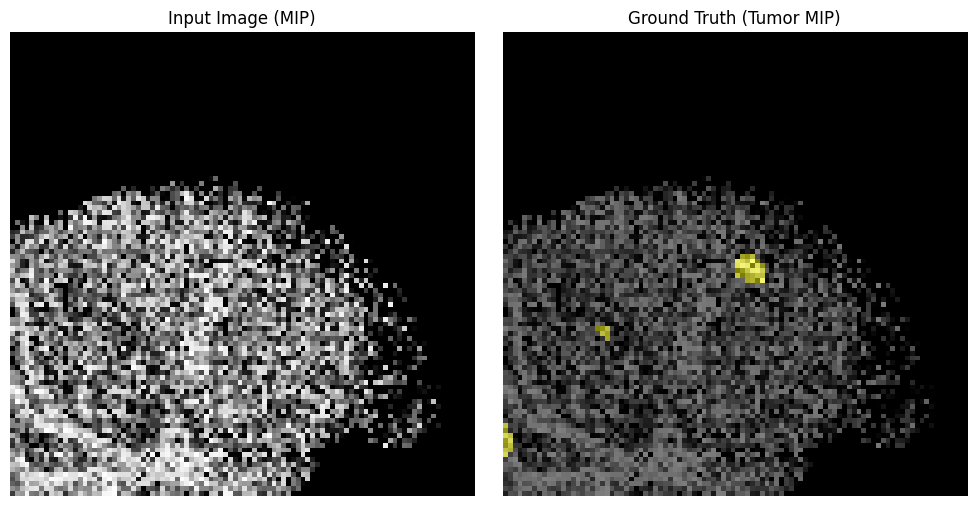

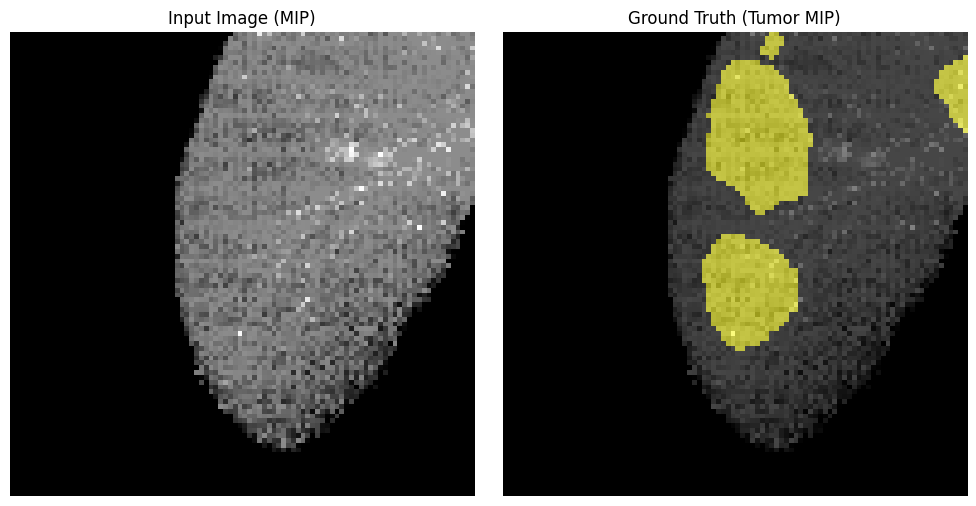

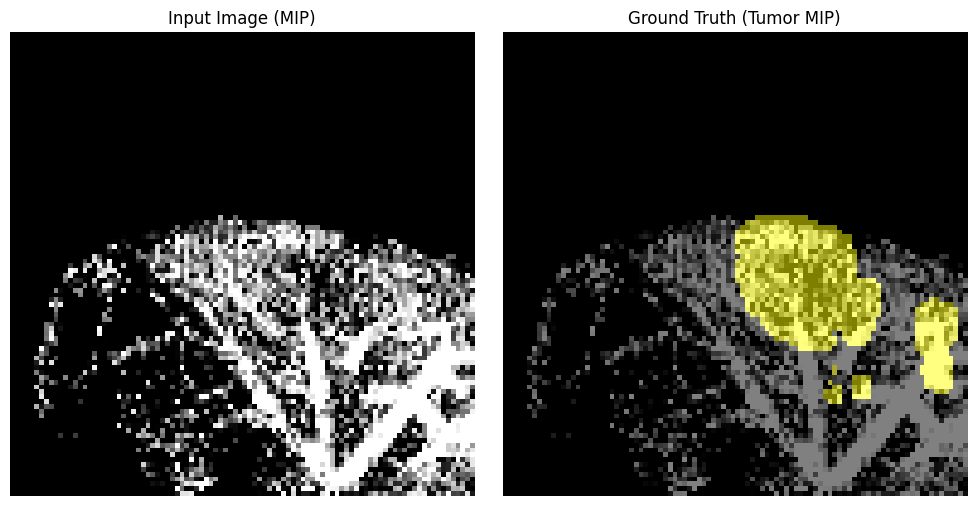

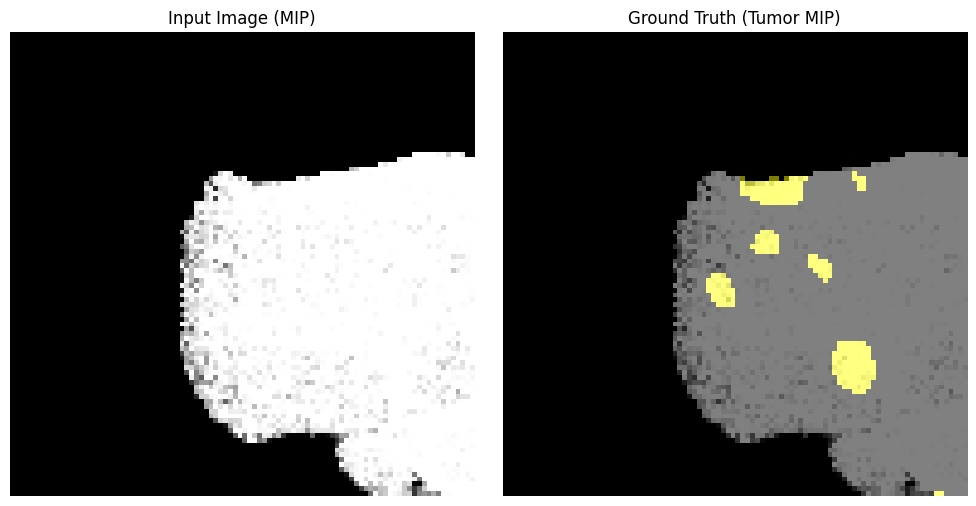

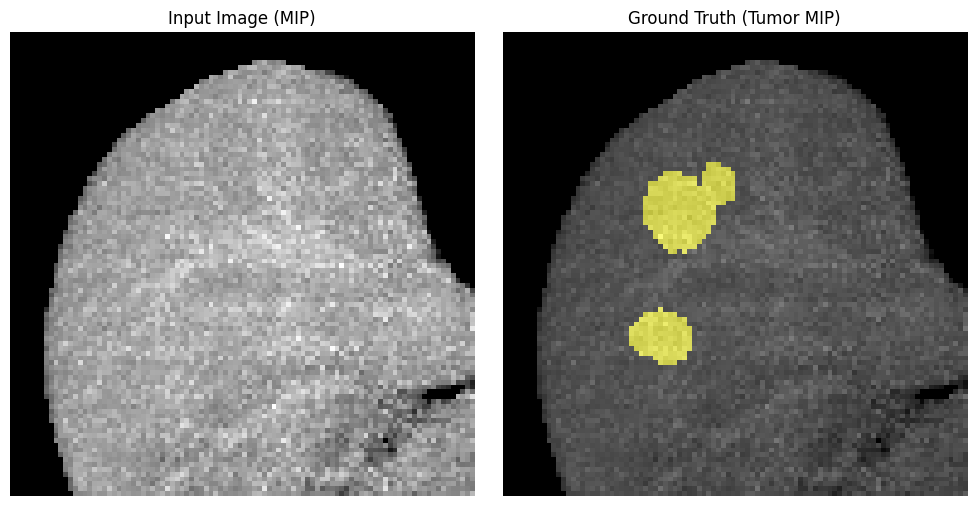

In [11]:
i = 0
for train_data in train_loader:
    i+= 1
    image = train_data["image"]
    label = train_data["label"]

    visualize_from_loader(image, label)
    if i == 5:
      break

## Training

In [12]:
criterion = TverskyLossWSigmoid().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate_train"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [13]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_tumor,
    loss_epochs,
    trains_epoch,
    ious_tumor,
    precisions_tumor,
    recalls_tumor,
    time_tmp
) = trainer_stage2(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    # max_epochs = config["max_epochs"],
    max_epochs = 5,
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=False,
    post_fix="tumor"
)

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/5 1/105 loss: 0.8907 time 5.08s
Epoch 1/5 2/105 loss: 0.8987 time 6.36s
Epoch 1/5 3/105 loss: 0.8967 time 2.87s
Epoch 1/5 4/105 loss: 0.9051 time 11.46s
Epoch 1/5 5/105 loss: 0.9070 time 7.19s
Epoch 1/5 6/105 loss: 0.9089 time 6.34s
Epoch 1/5 7/105 loss: 0.9107 time 11.82s
Epoch 1/5 8/105 loss: 0.9106 time 8.38s
Epoch 1/5 9/105 loss: 0.9123 time 4.51s
Epoch 1/5 10/105 loss: 0.9118 time 7.67s
Epoch 1/5 11/105 loss: 0.9104 time 5.74s
Epoch 1/5 12/105 loss: 0.9100 time 3.50s
Epoch 1/5 13/105 loss: 0.9093 time 2.81s
Epoch 1/5 14/105 loss: 0.9086 time 7.82s
Epoch 1/5 15/105 loss: 0.9077 time 6.42s
Epoch 1/5 16/105 loss: 0.9052 time 5.53s
Epoch 1/5 17/105 loss: 0.9050 time 5.09s
Epoch 1/5 18/105 loss: 0.9048 time 2.55s
Epoch 1/5 19/105 loss: 0.9004 time 6.93s
Epoch 1/5 20/105 loss: 0.9005 time 12.56s
Epoch 1/5 21/105 loss: 0.9002 time 1.44s
Epoch 1/5 22/105 loss: 0.9002 time 3.85s
Epoch 1/5 23/105 loss: 0.9001 time 5.95s
Epoch 1/5 24/105 loss: 0.8989 time 5.89s
Epoch 1/5 25/105 loss:

Final training epochs: 1/5 ---[loss: 0.8541] ---[time 509.17s]
INFO:kltn.utils.logger:Final training epochs: 1/5 ---[loss: 0.8541] ---[time 509.17s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/5 105/105 loss: 0.8541 time 1.22s


Val 1/5 1/26, Dice_Tumor: 0.000529, time 2.05s
INFO:kltn.utils.logger:Val 1/5 1/26, Dice_Tumor: 0.000529, time 2.05s
Val 1/5 2/26, Dice_Tumor: 0.104099, time 1.41s
INFO:kltn.utils.logger:Val 1/5 2/26, Dice_Tumor: 0.104099, time 1.41s
Val 1/5 3/26, Dice_Tumor: 0.000000, time 7.84s
INFO:kltn.utils.logger:Val 1/5 3/26, Dice_Tumor: 0.000000, time 7.84s
Val 1/5 4/26, Dice_Tumor: 0.181777, time 7.83s
INFO:kltn.utils.logger:Val 1/5 4/26, Dice_Tumor: 0.181777, time 7.83s
Val 1/5 5/26, Dice_Tumor: 0.023016, time 1.30s
INFO:kltn.utils.logger:Val 1/5 5/26, Dice_Tumor: 0.023016, time 1.30s
Val 1/5 6/26, Dice_Tumor: 0.350887, time 5.65s
INFO:kltn.utils.logger:Val 1/5 6/26, Dice_Tumor: 0.350887, time 5.65s
Val 1/5 7/26, Dice_Tumor: 0.000123, time 5.66s
INFO:kltn.utils.logger:Val 1/5 7/26, Dice_Tumor: 0.000123, time 5.66s
Val 1/5 8/26, Dice_Tumor: 0.000000, time 5.01s
INFO:kltn.utils.logger:Val 1/5 8/26, Dice_Tumor: 0.000000, time 5.01s
Val 1/5 9/26, Dice_Tumor: 0.098648, time 1.23s
INFO:kltn.utils.l

New best (0.000000 --> 0.039451). At epoch 1
Epoch 2/5 1/105 loss: 0.8375 time 6.03s
Epoch 2/5 2/105 loss: 0.8383 time 1.18s
Epoch 2/5 3/105 loss: 0.8171 time 2.01s
Epoch 2/5 4/105 loss: 0.8223 time 3.25s
Epoch 2/5 5/105 loss: 0.8241 time 6.59s
Epoch 2/5 6/105 loss: 0.8256 time 2.26s
Epoch 2/5 7/105 loss: 0.8020 time 5.36s
Epoch 2/5 8/105 loss: 0.8062 time 3.62s
Epoch 2/5 9/105 loss: 0.8099 time 1.69s
Epoch 2/5 10/105 loss: 0.8125 time 6.46s
Epoch 2/5 11/105 loss: 0.8150 time 1.67s
Epoch 2/5 12/105 loss: 0.8165 time 1.79s
Epoch 2/5 13/105 loss: 0.8179 time 3.01s
Epoch 2/5 14/105 loss: 0.8119 time 4.27s
Epoch 2/5 15/105 loss: 0.8131 time 1.94s
Epoch 2/5 16/105 loss: 0.8146 time 3.37s
Epoch 2/5 17/105 loss: 0.8156 time 2.67s
Epoch 2/5 18/105 loss: 0.8167 time 5.06s
Epoch 2/5 19/105 loss: 0.8174 time 8.93s
Epoch 2/5 20/105 loss: 0.8178 time 4.94s
Epoch 2/5 21/105 loss: 0.8184 time 9.03s
Epoch 2/5 22/105 loss: 0.8188 time 5.02s
Epoch 2/5 23/105 loss: 0.8176 time 5.42s
Epoch 2/5 24/105 loss

Final training epochs: 2/5 ---[loss: 0.7882] ---[time 509.60s]
INFO:kltn.utils.logger:Final training epochs: 2/5 ---[loss: 0.7882] ---[time 509.60s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/5 105/105 loss: 0.7882 time 5.97s


Val 2/5 1/26, Dice_Tumor: 0.001722, time 1.56s
INFO:kltn.utils.logger:Val 2/5 1/26, Dice_Tumor: 0.001722, time 1.56s
Val 2/5 2/26, Dice_Tumor: 0.248324, time 1.33s
INFO:kltn.utils.logger:Val 2/5 2/26, Dice_Tumor: 0.248324, time 1.33s
Val 2/5 3/26, Dice_Tumor: 0.000000, time 7.34s
INFO:kltn.utils.logger:Val 2/5 3/26, Dice_Tumor: 0.000000, time 7.34s
Val 2/5 4/26, Dice_Tumor: 0.146269, time 7.53s
INFO:kltn.utils.logger:Val 2/5 4/26, Dice_Tumor: 0.146269, time 7.53s
Val 2/5 5/26, Dice_Tumor: 0.052988, time 1.54s
INFO:kltn.utils.logger:Val 2/5 5/26, Dice_Tumor: 0.052988, time 1.54s
Val 2/5 6/26, Dice_Tumor: 0.502562, time 5.59s
INFO:kltn.utils.logger:Val 2/5 6/26, Dice_Tumor: 0.502562, time 5.59s
Val 2/5 7/26, Dice_Tumor: 0.000000, time 5.47s
INFO:kltn.utils.logger:Val 2/5 7/26, Dice_Tumor: 0.000000, time 5.47s
Val 2/5 8/26, Dice_Tumor: 0.000000, time 4.57s
INFO:kltn.utils.logger:Val 2/5 8/26, Dice_Tumor: 0.000000, time 4.57s
Val 2/5 9/26, Dice_Tumor: 0.263709, time 1.20s
INFO:kltn.utils.l

New best (0.039451 --> 0.069277). At epoch 2
Epoch 3/5 1/105 loss: 0.7888 time 3.02s
Epoch 3/5 2/105 loss: 0.7433 time 3.00s
Epoch 3/5 3/105 loss: 0.7605 time 1.46s
Epoch 3/5 4/105 loss: 0.7530 time 7.81s
Epoch 3/5 5/105 loss: 0.7592 time 8.68s
Epoch 3/5 6/105 loss: 0.7630 time 5.63s
Epoch 3/5 7/105 loss: 0.7660 time 4.75s
Epoch 3/5 8/105 loss: 0.7694 time 5.09s
Epoch 3/5 9/105 loss: 0.7710 time 2.83s
Epoch 3/5 10/105 loss: 0.7702 time 7.54s
Epoch 3/5 11/105 loss: 0.7686 time 3.05s
Epoch 3/5 12/105 loss: 0.7691 time 5.23s
Epoch 3/5 13/105 loss: 0.7648 time 2.62s
Epoch 3/5 14/105 loss: 0.7650 time 1.96s
Epoch 3/5 15/105 loss: 0.7659 time 10.17s
Epoch 3/5 16/105 loss: 0.7670 time 6.31s
Epoch 3/5 17/105 loss: 0.7676 time 6.54s
Epoch 3/5 18/105 loss: 0.7622 time 3.63s
Epoch 3/5 19/105 loss: 0.7635 time 1.66s
Epoch 3/5 20/105 loss: 0.7595 time 7.18s
Epoch 3/5 21/105 loss: 0.7603 time 1.23s
Epoch 3/5 22/105 loss: 0.7592 time 2.26s
Epoch 3/5 23/105 loss: 0.7604 time 3.99s
Epoch 3/5 24/105 los

Final training epochs: 3/5 ---[loss: 0.7400] ---[time 502.27s]
INFO:kltn.utils.logger:Final training epochs: 3/5 ---[loss: 0.7400] ---[time 502.27s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/5 105/105 loss: 0.7400 time 7.23s


Val 3/5 1/26, Dice_Tumor: 0.003383, time 1.59s
INFO:kltn.utils.logger:Val 3/5 1/26, Dice_Tumor: 0.003383, time 1.59s
Val 3/5 2/26, Dice_Tumor: 0.103515, time 1.33s
INFO:kltn.utils.logger:Val 3/5 2/26, Dice_Tumor: 0.103515, time 1.33s
Val 3/5 3/26, Dice_Tumor: 0.000000, time 7.07s
INFO:kltn.utils.logger:Val 3/5 3/26, Dice_Tumor: 0.000000, time 7.07s
Val 3/5 4/26, Dice_Tumor: 0.000000, time 7.46s
INFO:kltn.utils.logger:Val 3/5 4/26, Dice_Tumor: 0.000000, time 7.46s
Val 3/5 5/26, Dice_Tumor: 0.049707, time 1.28s
INFO:kltn.utils.logger:Val 3/5 5/26, Dice_Tumor: 0.049707, time 1.28s
Val 3/5 6/26, Dice_Tumor: 0.328361, time 6.26s
INFO:kltn.utils.logger:Val 3/5 6/26, Dice_Tumor: 0.328361, time 6.26s
Val 3/5 7/26, Dice_Tumor: 0.000000, time 5.46s
INFO:kltn.utils.logger:Val 3/5 7/26, Dice_Tumor: 0.000000, time 5.46s
Val 3/5 8/26, Dice_Tumor: 0.000000, time 4.24s
INFO:kltn.utils.logger:Val 3/5 8/26, Dice_Tumor: 0.000000, time 4.24s
Val 3/5 9/26, Dice_Tumor: 0.324826, time 1.47s
INFO:kltn.utils.l

Epoch 4/5 1/105 loss: 0.7520 time 6.42s
Epoch 4/5 2/105 loss: 0.7247 time 6.15s
Epoch 4/5 3/105 loss: 0.7356 time 5.98s
Epoch 4/5 4/105 loss: 0.7390 time 6.91s
Epoch 4/5 5/105 loss: 0.7109 time 5.27s
Epoch 4/5 6/105 loss: 0.7102 time 3.53s
Epoch 4/5 7/105 loss: 0.7090 time 1.66s
Epoch 4/5 8/105 loss: 0.7144 time 5.85s
Epoch 4/5 9/105 loss: 0.7120 time 2.29s
Epoch 4/5 10/105 loss: 0.7158 time 3.78s
Epoch 4/5 11/105 loss: 0.7189 time 3.44s
Epoch 4/5 12/105 loss: 0.7191 time 1.99s
Epoch 4/5 13/105 loss: 0.7216 time 1.99s
Epoch 4/5 14/105 loss: 0.7230 time 2.64s
Epoch 4/5 15/105 loss: 0.7247 time 2.45s
Epoch 4/5 16/105 loss: 0.7265 time 5.77s
Epoch 4/5 17/105 loss: 0.7279 time 1.89s
Epoch 4/5 18/105 loss: 0.7297 time 2.10s
Epoch 4/5 19/105 loss: 0.7286 time 6.79s
Epoch 4/5 20/105 loss: 0.7269 time 6.27s
Epoch 4/5 21/105 loss: 0.7248 time 3.05s
Epoch 4/5 22/105 loss: 0.7252 time 5.05s
Epoch 4/5 23/105 loss: 0.7192 time 7.42s
Epoch 4/5 24/105 loss: 0.7169 time 5.51s
Epoch 4/5 25/105 loss: 0.

Final training epochs: 4/5 ---[loss: 0.7016] ---[time 498.41s]
INFO:kltn.utils.logger:Final training epochs: 4/5 ---[loss: 0.7016] ---[time 498.41s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/5 105/105 loss: 0.7016 time 2.61s


Val 4/5 1/26, Dice_Tumor: 0.007373, time 1.62s
INFO:kltn.utils.logger:Val 4/5 1/26, Dice_Tumor: 0.007373, time 1.62s
Val 4/5 2/26, Dice_Tumor: 0.346588, time 1.42s
INFO:kltn.utils.logger:Val 4/5 2/26, Dice_Tumor: 0.346588, time 1.42s
Val 4/5 3/26, Dice_Tumor: 0.000000, time 7.12s
INFO:kltn.utils.logger:Val 4/5 3/26, Dice_Tumor: 0.000000, time 7.12s
Val 4/5 4/26, Dice_Tumor: 0.001535, time 7.97s
INFO:kltn.utils.logger:Val 4/5 4/26, Dice_Tumor: 0.001535, time 7.97s
Val 4/5 5/26, Dice_Tumor: 0.179869, time 1.58s
INFO:kltn.utils.logger:Val 4/5 5/26, Dice_Tumor: 0.179869, time 1.58s
Val 4/5 6/26, Dice_Tumor: 0.429392, time 5.44s
INFO:kltn.utils.logger:Val 4/5 6/26, Dice_Tumor: 0.429392, time 5.44s
Val 4/5 7/26, Dice_Tumor: 0.000000, time 5.90s
INFO:kltn.utils.logger:Val 4/5 7/26, Dice_Tumor: 0.000000, time 5.90s
Val 4/5 8/26, Dice_Tumor: 0.000000, time 4.26s
INFO:kltn.utils.logger:Val 4/5 8/26, Dice_Tumor: 0.000000, time 4.26s
Val 4/5 9/26, Dice_Tumor: 0.381739, time 1.22s
INFO:kltn.utils.l

New best (0.069277 --> 0.082359). At epoch 4
Epoch 5/5 1/105 loss: 0.7400 time 6.17s
Epoch 5/5 2/105 loss: 0.7404 time 1.89s
Epoch 5/5 3/105 loss: 0.7428 time 1.90s
Epoch 5/5 4/105 loss: 0.7369 time 5.28s
Epoch 5/5 5/105 loss: 0.7379 time 4.70s
Epoch 5/5 6/105 loss: 0.7043 time 3.86s
Epoch 5/5 7/105 loss: 0.7095 time 2.57s
Epoch 5/5 8/105 loss: 0.7131 time 4.03s
Epoch 5/5 9/105 loss: 0.7132 time 2.70s
Epoch 5/5 10/105 loss: 0.7164 time 6.70s
Epoch 5/5 11/105 loss: 0.6939 time 6.13s
Epoch 5/5 12/105 loss: 0.6974 time 1.94s
Epoch 5/5 13/105 loss: 0.6908 time 6.18s
Epoch 5/5 14/105 loss: 0.6888 time 5.50s
Epoch 5/5 15/105 loss: 0.6870 time 5.47s
Epoch 5/5 16/105 loss: 0.6798 time 5.45s
Epoch 5/5 17/105 loss: 0.6753 time 1.19s
Epoch 5/5 18/105 loss: 0.6788 time 3.19s
Epoch 5/5 19/105 loss: 0.6821 time 1.21s
Epoch 5/5 20/105 loss: 0.6810 time 3.69s
Epoch 5/5 21/105 loss: 0.6840 time 6.17s
Epoch 5/5 22/105 loss: 0.6775 time 1.49s
Epoch 5/5 23/105 loss: 0.6800 time 1.79s
Epoch 5/5 24/105 loss

Final training epochs: 5/5 ---[loss: 0.6811] ---[time 496.72s]
INFO:kltn.utils.logger:Final training epochs: 5/5 ---[loss: 0.6811] ---[time 496.72s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/5 105/105 loss: 0.6811 time 6.10s


Val 5/5 1/26, Dice_Tumor: 0.005535, time 1.86s
INFO:kltn.utils.logger:Val 5/5 1/26, Dice_Tumor: 0.005535, time 1.86s
Val 5/5 2/26, Dice_Tumor: 0.261209, time 1.32s
INFO:kltn.utils.logger:Val 5/5 2/26, Dice_Tumor: 0.261209, time 1.32s
Val 5/5 3/26, Dice_Tumor: 0.000000, time 6.65s
INFO:kltn.utils.logger:Val 5/5 3/26, Dice_Tumor: 0.000000, time 6.65s
Val 5/5 4/26, Dice_Tumor: 0.466701, time 7.86s
INFO:kltn.utils.logger:Val 5/5 4/26, Dice_Tumor: 0.466701, time 7.86s
Val 5/5 5/26, Dice_Tumor: 0.078005, time 1.26s
INFO:kltn.utils.logger:Val 5/5 5/26, Dice_Tumor: 0.078005, time 1.26s
Val 5/5 6/26, Dice_Tumor: 0.606014, time 5.40s
INFO:kltn.utils.logger:Val 5/5 6/26, Dice_Tumor: 0.606014, time 5.40s
Val 5/5 7/26, Dice_Tumor: 0.000000, time 5.63s
INFO:kltn.utils.logger:Val 5/5 7/26, Dice_Tumor: 0.000000, time 5.63s
Val 5/5 8/26, Dice_Tumor: 0.000000, time 4.18s
INFO:kltn.utils.logger:Val 5/5 8/26, Dice_Tumor: 0.000000, time 4.18s
Val 5/5 9/26, Dice_Tumor: 0.342119, time 1.21s
INFO:kltn.utils.l

New best (0.082359 --> 0.092948). At epoch 5


In [ ]:
import json
path_save_result = f"/content/drive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}_tumor.json"

results = {
    "dice_tumor": [float(x) for x in np.array(dices_tumor, dtype=np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_tumor": [float(x) for x in np.array(ious_tumor, dtype=np.float32)],
    "precision_tumor": [float(x) for x in np.array(precisions_tumor, dtype=np.float32)],
    "recall_tumor": [float(x) for x in np.array(recalls_tumor, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)